# Лаборатоная работа №2.
## Порофиев Е.А. группа 3375

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
import random
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.graph_objects as go
import plotly.io as pio
import warnings
warnings.filterwarnings('ignore')

pio.renderers.default = 'jupyterlab'

### Добавляем новый столбец
Productivity_Score(1-10) - числовой, субъективная оценка своей продуктивности респондентом

Правила для генерации новый данных:

Базовый балл: 6

Влияние данных из сущуствующих столбцов на новые данные:
- Высокий сон (Sleep_Quality >= 7) и низкий стресс (Stress_Level <= 4): +2 балла
- Умеренное экранное время (Daily_Screen_Time между 3 и 5 часами): +1 балл
- Высокое экранное время (Daily_Screen_Time > 6 часов): -1 балл
- Регулярные упражнения (Exercise_Frequency >= 3 раза в неделю): +1 балл
- Длительное воздержание от соцсетей (Days_Without_Social_Media >= 4): +1 балл

Так же добавим 15% шанс на то, что новых данных будут существовать выбросы, либо же каждая 61 ячейка будет содержать выброс

In [2]:
df = pd.read_csv('Mental_Health_and_Social_Media_Balance_Dataset.csv')

counter = 0

def calculate_productivity_score(row):
    base_score = 6
    
    if row['Sleep_Quality(1-10)'] >= 7 and row['Stress_Level(1-10)'] <= 4:
        base_score += 2
    elif row['Sleep_Quality(1-10)'] <= 4 and row['Stress_Level(1-10)'] >= 8:
        base_score -= 2
    
    if 3 <= row['Daily_Screen_Time(hrs)'] <= 5:
        base_score += 1
    elif row['Daily_Screen_Time(hrs)'] > 6:
        base_score -= 1
    
    if row['Exercise_Frequency(week)'] >= 3:
        base_score += 1
    elif row['Exercise_Frequency(week)'] == 0:
        base_score -= 1
    
    if row['Days_Without_Social_Media'] >= 4:
        base_score += 1
    elif row['Days_Without_Social_Media'] == 0:
        base_score -= 1
    
    base_score = max(1, min(10, base_score))

    global counter
    counter += 1
    
    if random.random() < 0.15 or counter % 61 == 0:
        outlier_type = random.choice(['extreme_low', 'extreme_high', 'inconsistent'])
        
        if outlier_type == 'extreme_low':
            return 0
        elif outlier_type == 'extreme_high':
            return 13
        else:
            if base_score > 5:
                return 0
            else:
                return 13
    
    return base_score

df['Productivity_Score(1-10)'] = df.apply(calculate_productivity_score, axis=1)

df.to_csv('Mental_Health_and_Social_Media_Balance_Dataset_with_Productivity.csv', index=False)

print(df.head())

  User_ID  Age  Gender  Daily_Screen_Time(hrs)  Sleep_Quality(1-10)  \
0    U001   44    Male                     3.1                  7.0   
1    U002   30   Other                     5.1                  7.0   
2    U003   23   Other                     7.4                  6.0   
3    U004   36  Female                     5.7                  7.0   
4    U005   34  Female                     7.0                  4.0   

   Stress_Level(1-10)  Days_Without_Social_Media  Exercise_Frequency(week)  \
0                 6.0                        2.0                       5.0   
1                 8.0                        5.0                       3.0   
2                 7.0                        1.0                       3.0   
3                 8.0                        1.0                       1.0   
4                 7.0                        5.0                       1.0   

  Social_Media_Platform  Happiness_Index(1-10)  Productivity_Score(1-10)  
0              Facebook      

### Нахождение среднего и СКО для Productivity_Score(1-10)

In [3]:
productivity_mid = df['Productivity_Score(1-10)'].mean()
productivity_sd = df['Productivity_Score(1-10)'].std()


print(f'Productivity_Score(1-10): среднее = {productivity_mid}, СКО = {productivity_sd}')

Productivity_Score(1-10): среднее = 6.438, СКО = 3.1670516940627493


### Построение гристорамм распределения для Productivity_Score(1-10)

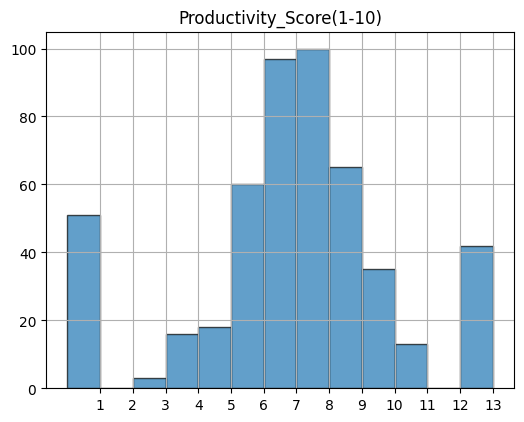

In [4]:
bins_config = {
    'Productivity_Score(1-10)': range(0, 14)
}

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.ravel()

columns = ['Productivity_Score(1-10)']

for i, col in enumerate(columns):
    if col in bins_config:
        bins = bins_config[col]
        df[col].hist(bins=bins, ax=axes[i], edgecolor='black', alpha=0.7)
        axes[i].set_title(col)
        
        if isinstance(bins, range):
            axes[i].set_xticks(list(bins)[1:])
    
for j in range(len(columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Обнаружение выбросов методом IQR

In [5]:
def detect_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    return (data < lower_bound) | (data > upper_bound)


age_out = detect_outliers_iqr(df['Age'])
screen_time_out = detect_outliers_iqr(df['Daily_Screen_Time(hrs)'])
sleep_out = detect_outliers_iqr(df['Sleep_Quality(1-10)'])
stress_out = detect_outliers_iqr(df['Stress_Level(1-10)'])
days_wo_sm_out = detect_outliers_iqr(df['Days_Without_Social_Media'])
sport_out = detect_outliers_iqr(df['Exercise_Frequency(week)'])
happiness_out = detect_outliers_iqr(df['Happiness_Index(1-10)'])
productivity_out = detect_outliers_iqr(df['Productivity_Score(1-10)'])

print(f'Кол-во выбросов в Age = {sum(age_out)}')
print(f'Кол-во выбросов в Daily_Screen_Time(hrs) = {sum(screen_time_out)}')
print(f'Кол-во выбросов в Sleep_Quality(1-10) = {sum(sleep_out)}')
print(f'Кол-во выбросов в Stress_Level(1-10) = {sum(stress_out)}')
print(f'Кол-во выбросов в Days_Without_Social_Media = {sum(days_wo_sm_out)}')
print(f'Кол-во выбросов в Exercise_Frequency(week) = {sum(sport_out)}')
print(f'Кол-во выбросов в Happiness_Index(1-10) = {sum(happiness_out)}')
print(f'Кол-во выбросов в Productivity_Score(1-10) = {sum(productivity_out)}') 

Кол-во выбросов в Age = 0
Кол-во выбросов в Daily_Screen_Time(hrs) = 2
Кол-во выбросов в Sleep_Quality(1-10) = 0
Кол-во выбросов в Stress_Level(1-10) = 1
Кол-во выбросов в Days_Without_Social_Media = 0
Кол-во выбросов в Exercise_Frequency(week) = 2
Кол-во выбросов в Happiness_Index(1-10) = 0
Кол-во выбросов в Productivity_Score(1-10) = 93


### Визуализируем выбросы с помощью диаграммы рассеивания и коробчатых диаграмм

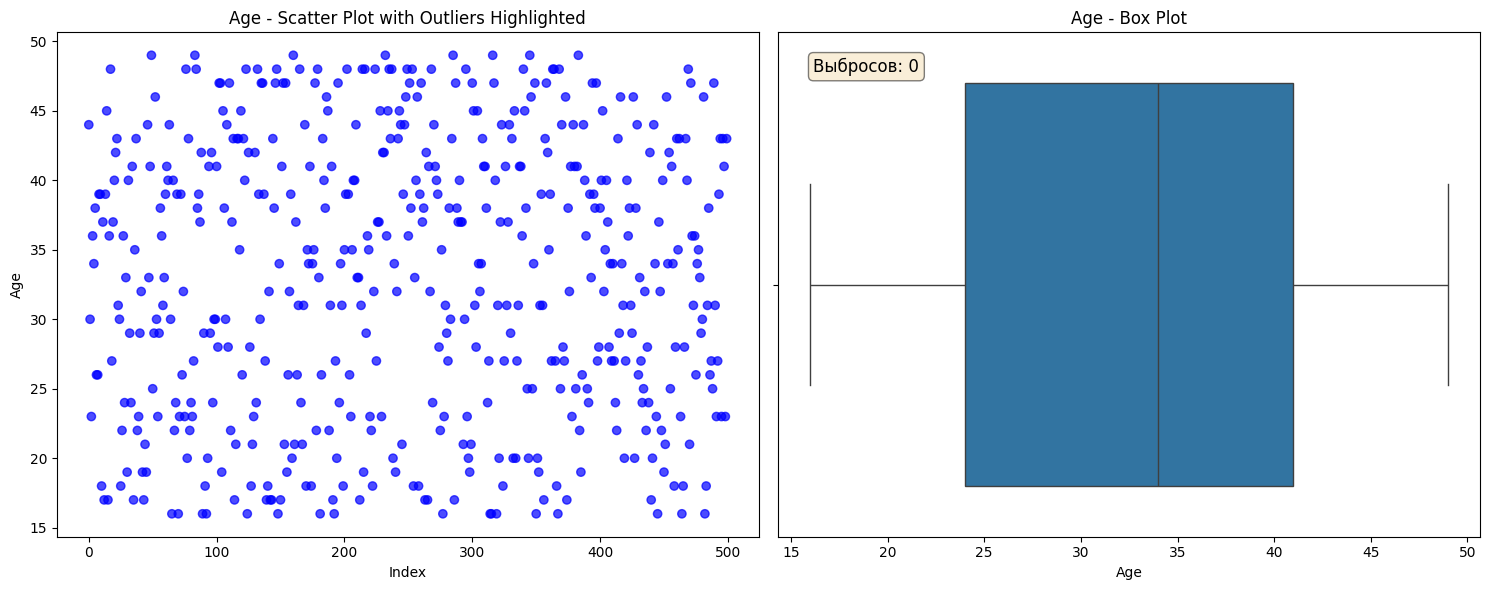

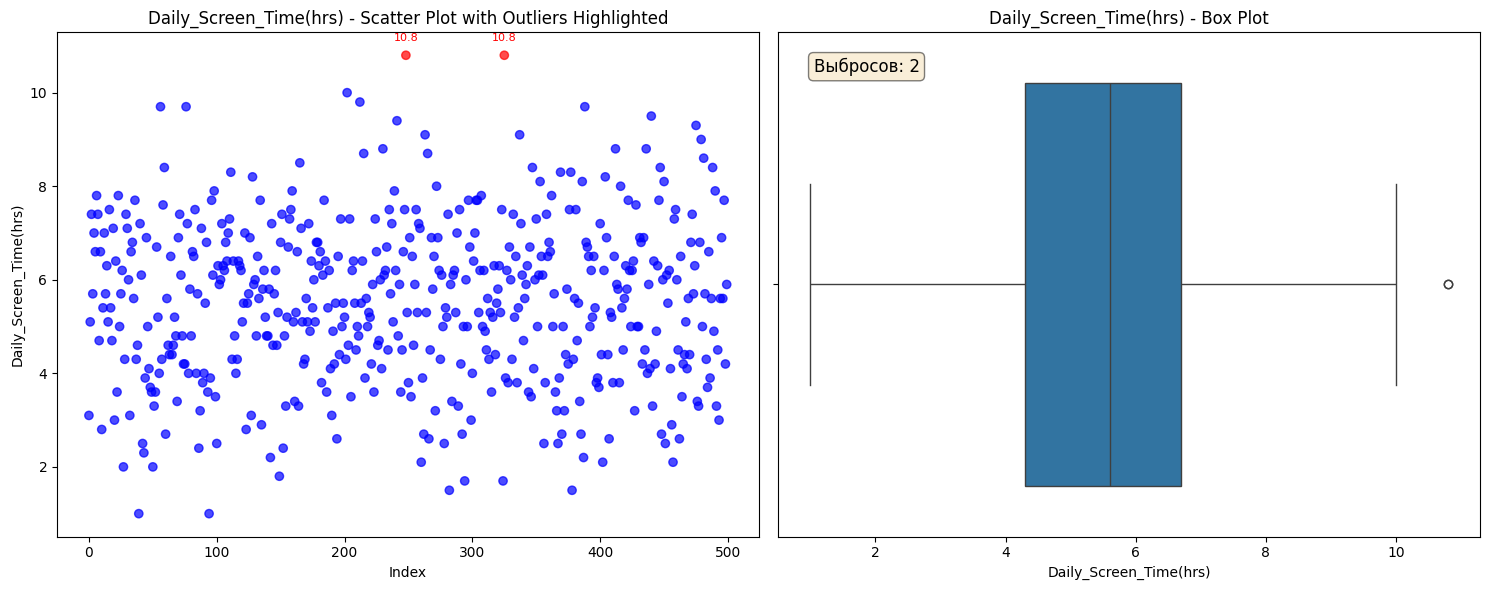


Статистика выбросов для Daily_Screen_Time(hrs):
Количество: 2
Значения: [10.8 10.8]
Индексы: [248, 325]
----------------------------------------------------------------------------------------------------


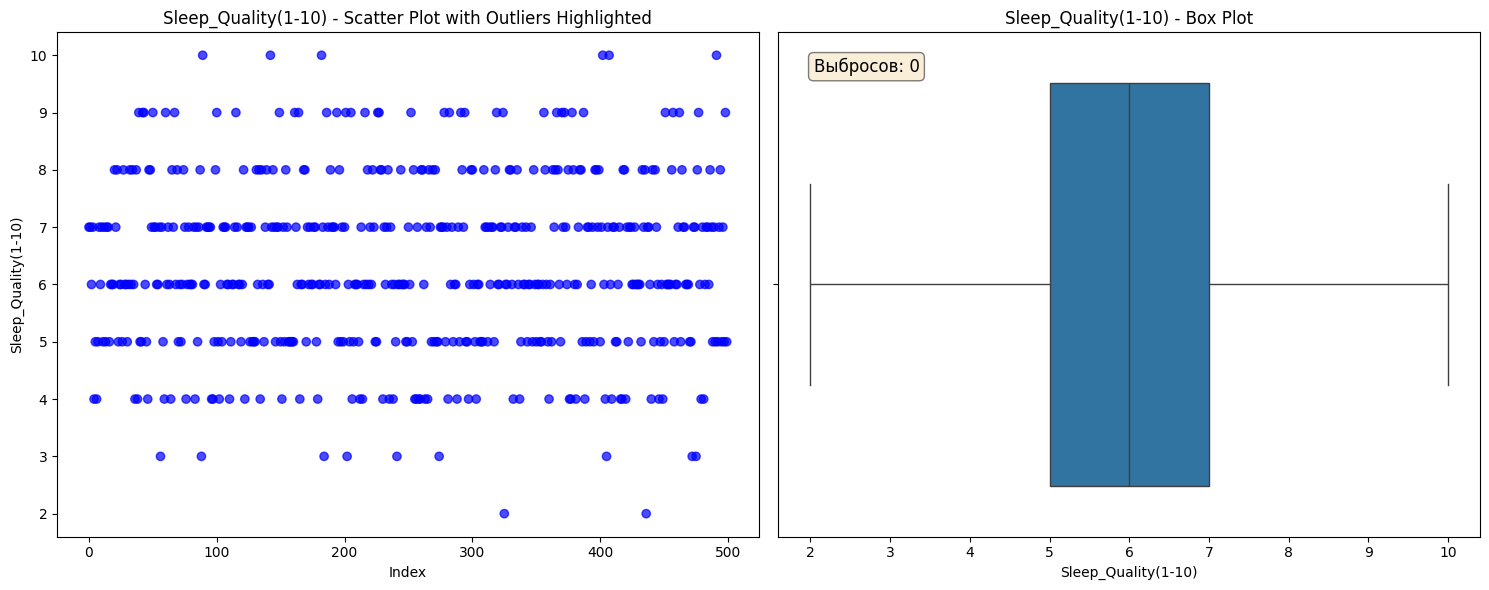

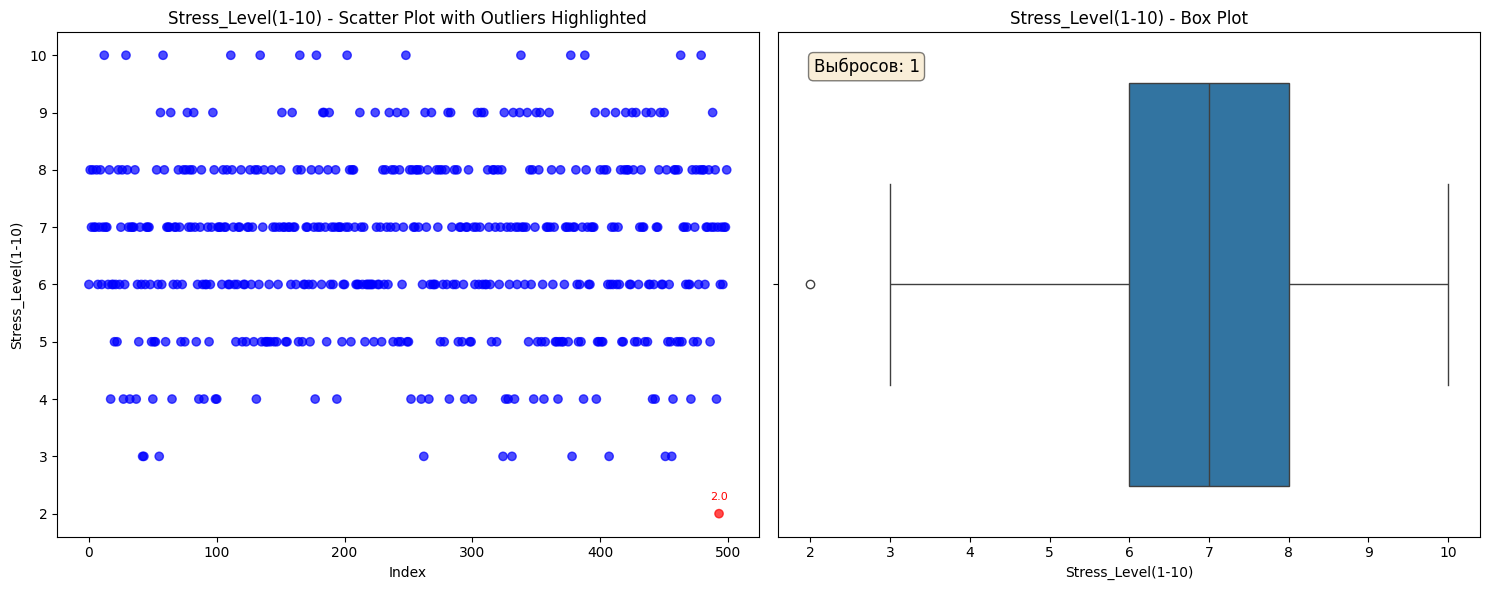


Статистика выбросов для Stress_Level(1-10):
Количество: 1
Значения: [2.]
Индексы: [493]
----------------------------------------------------------------------------------------------------


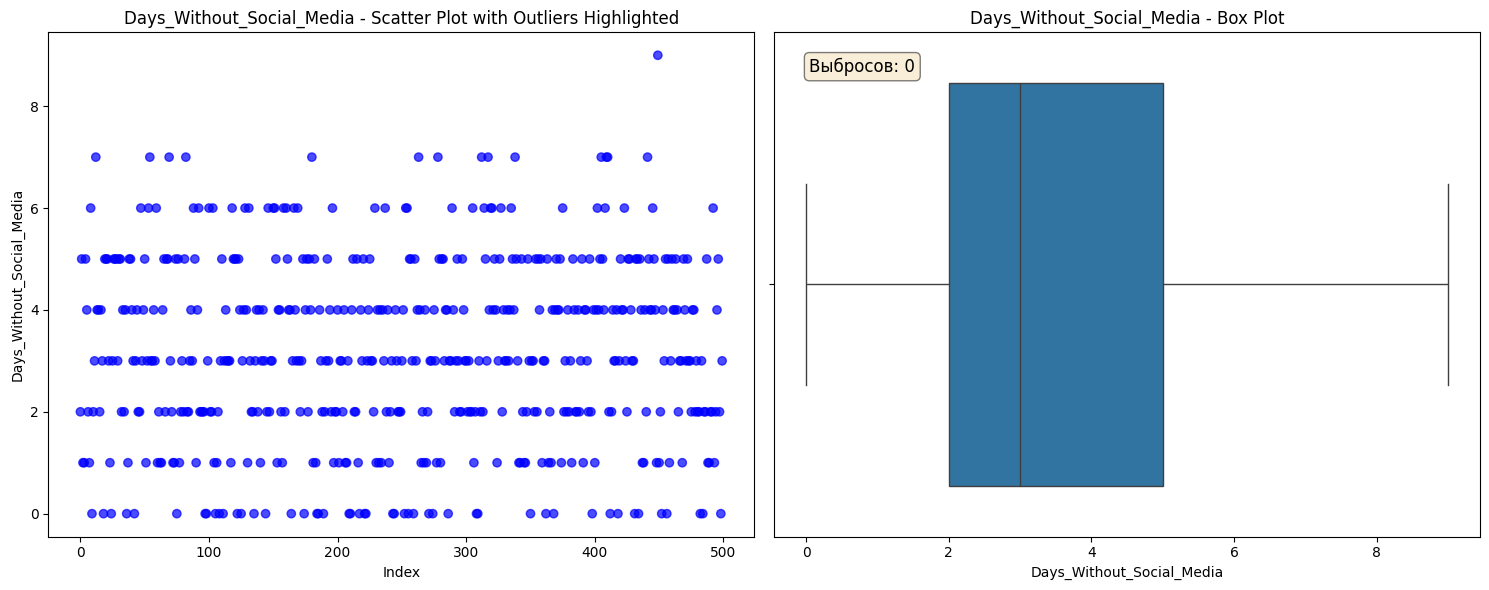

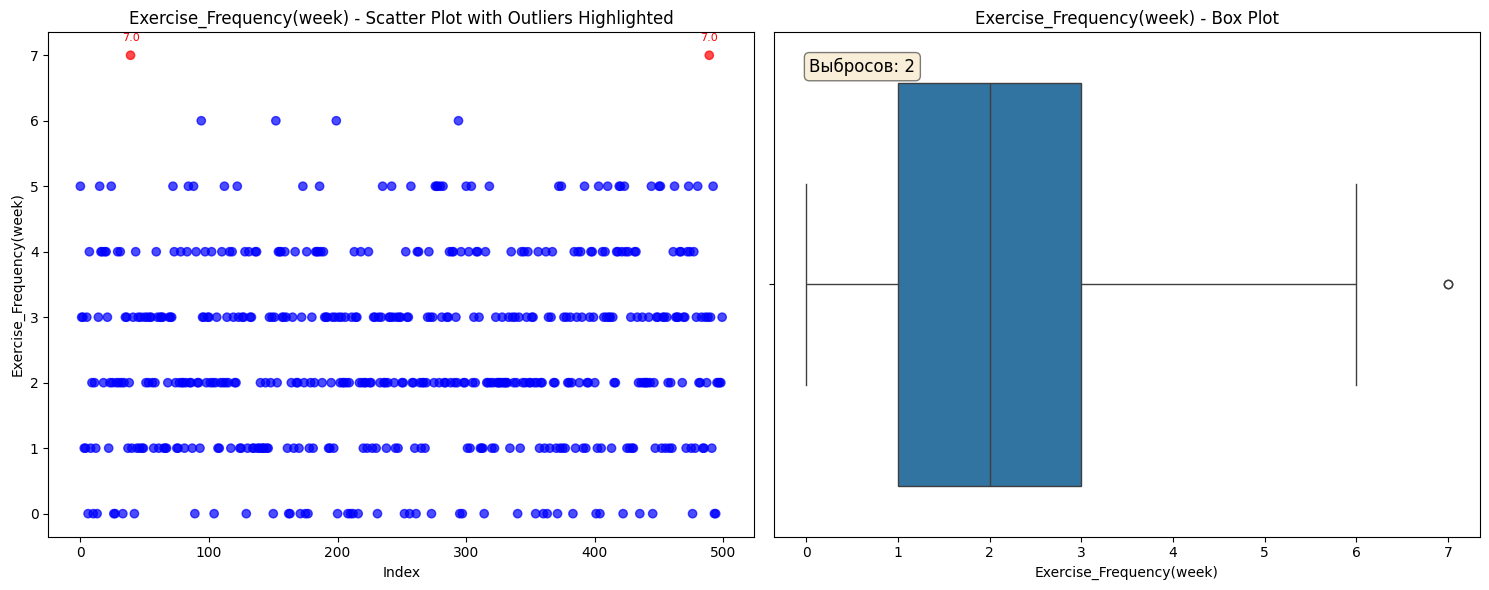


Статистика выбросов для Exercise_Frequency(week):
Количество: 2
Значения: [7. 7.]
Индексы: [39, 489]
----------------------------------------------------------------------------------------------------


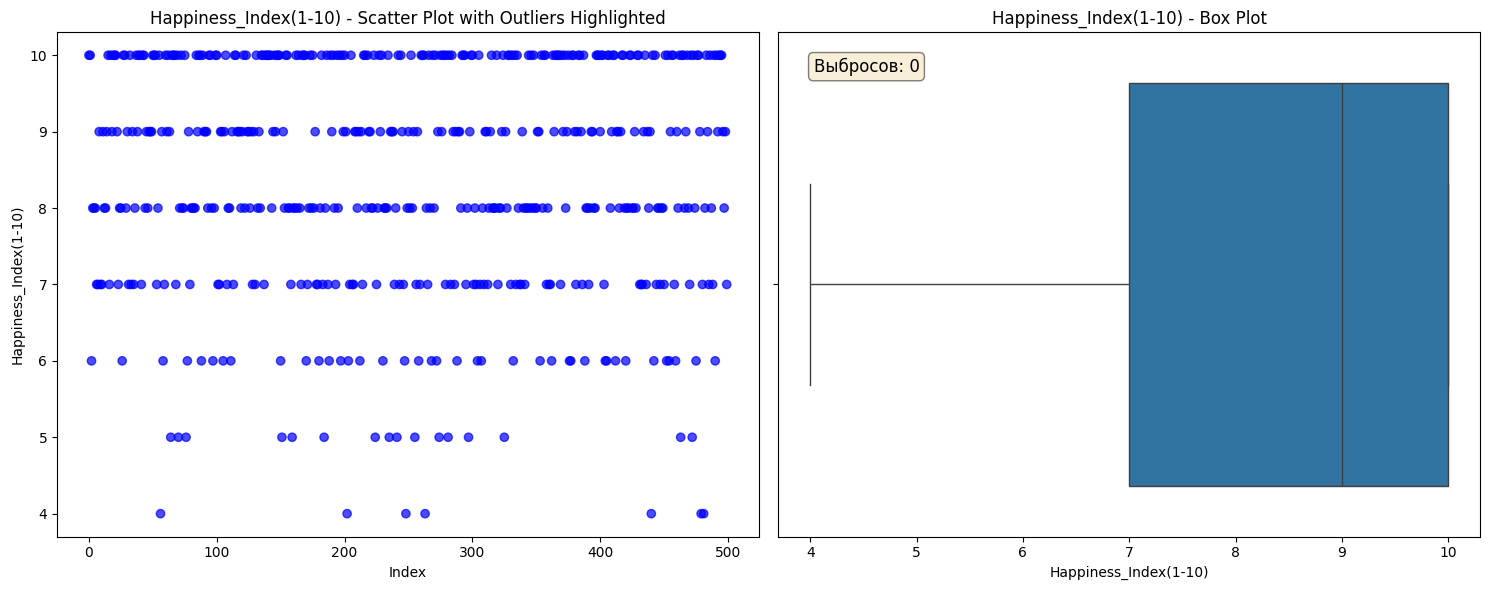

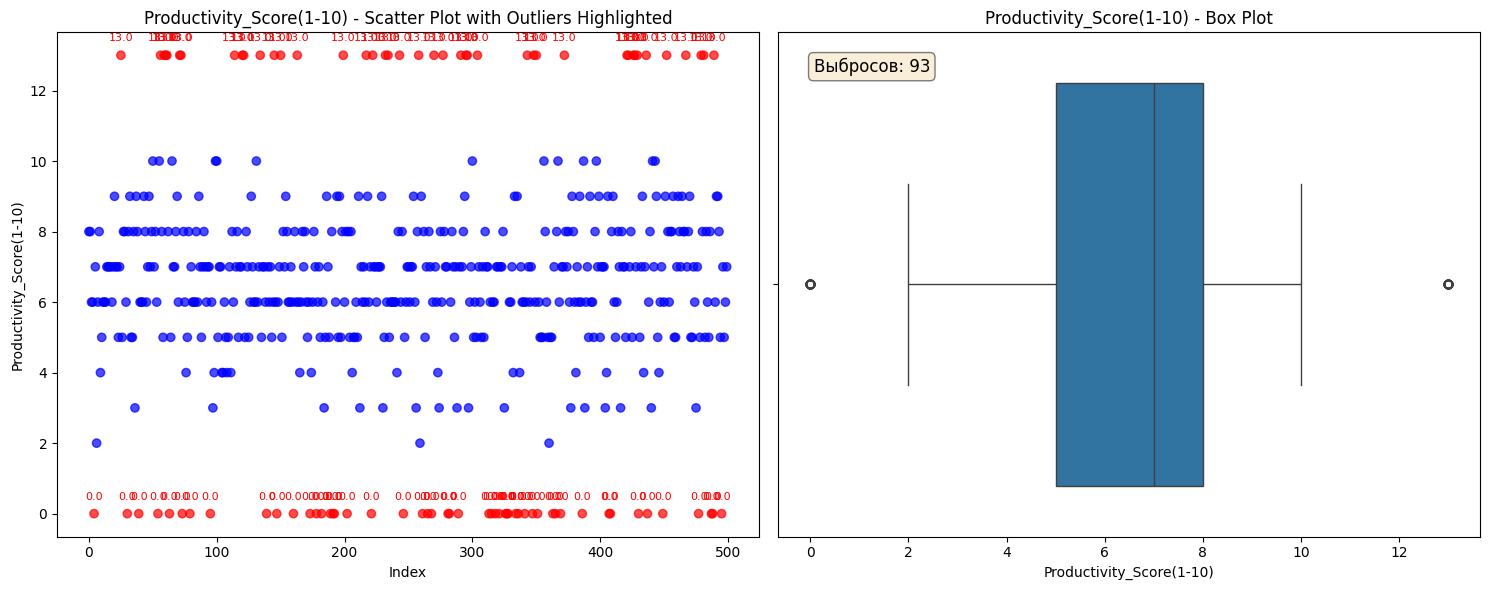


Статистика выбросов для Productivity_Score(1-10):
Количество: 93
Значения: [ 0 13  0  0  0 13 13 13 13  0 13 13  0  0  0 13 13 13 13  0 13  0 13  0
 13  0  0  0  0  0  0 13  0 13  0 13 13 13 13  0 13  0  0  0 13 13  0  0
  0 13 13 13 13  0  0  0  0  0  0  0  0  0  0 13  0 13 13  0  0  0  0 13
  0  0  0 13 13 13 13 13  0 13  0  0 13 13  0 13 13  0  0 13  0]
Индексы: [4, 25, 30, 39, 54, 56, 59, 60, 61, 63, 71, 72, 73, 79, 95, 114, 120, 121, 134, 139, 145, 147, 150, 160, 163, 173, 178, 182, 189, 191, 192, 199, 202, 217, 221, 222, 232, 234, 243, 246, 258, 261, 265, 268, 270, 277, 281, 282, 289, 291, 295, 296, 304, 313, 315, 318, 321, 326, 327, 328, 334, 336, 341, 343, 347, 348, 350, 351, 363, 365, 369, 372, 386, 407, 408, 421, 422, 426, 427, 429, 430, 436, 437, 449, 452, 467, 477, 479, 481, 487, 488, 489, 495]
----------------------------------------------------------------------------------------------------


In [6]:
attributes = [
    ('Age', age_out),
    ('Daily_Screen_Time(hrs)', screen_time_out),
    ('Sleep_Quality(1-10)', sleep_out),
    ('Stress_Level(1-10)', stress_out),
    ('Days_Without_Social_Media', days_wo_sm_out),
    ('Exercise_Frequency(week)', sport_out),
    ('Happiness_Index(1-10)', happiness_out),
    ('Productivity_Score(1-10)', productivity_out)
]

for col, outliers in attributes:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    data = df[col]
    
    colors = ['blue' if not x else 'red' for x in outliers]
    ax1.scatter(range(len(data)), data, c=colors, alpha=0.7)
    ax1.set_title(f'{col} - Scatter Plot with Outliers Highlighted')
    ax1.set_xlabel('Index')
    ax1.set_ylabel(col)
    
    outlier_indices = outliers[outliers].index
    for idx in outlier_indices:
        ax1.annotate(f'{data[idx]:.1f}', 
                    (idx, data[idx]),
                    textcoords="offset points",
                    xytext=(0,10),
                    ha='center',
                    fontsize=8,
                    color='red')
    
    sns.boxplot(x=data, ax=ax2)
    ax2.set_title(f'{col} - Box Plot')
    ax2.set_xlabel(col)
    
    num_outliers = sum(outliers)
    ax2.text(0.05, 0.95, f'Выбросов: {num_outliers}', 
             transform=ax2.transAxes, fontsize=12,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.show()
    
    if num_outliers > 0:
        outlier_data = data[outliers]
        print(f"\nСтатистика выбросов для {col}:")
        print(f"Количество: {num_outliers}")
        print(f"Значения: {outlier_data.values}")
        print(f"Индексы: {outlier_data.index.tolist()}")
        print("-" * 100)


### Удалим те строки, где встречаются выбросы

In [7]:
numeric_columns = ['Age', 'Daily_Screen_Time(hrs)', 'Sleep_Quality(1-10)', 
                   'Stress_Level(1-10)', 'Days_Without_Social_Media', 
                   'Exercise_Frequency(week)', 'Happiness_Index(1-10)', 
                   'Productivity_Score(1-10)']

outlier_mask = pd.Series([False] * len(df))

for column in numeric_columns:
    column_outliers = detect_outliers_iqr(df[column])
    outlier_mask = outlier_mask | column_outliers
    print(f'Кол-во выбросов в {column} = {sum(column_outliers)}')

df_cleaned = df[~outlier_mask]

df_cleaned.to_csv('Mental_Health_and_Social_Media_Balance_Dataset_Cleaned.csv', index=False)

print(f"\nИсходный размер датасета: {df.shape}")
print(f"Размер датасета после удаления выбросов: {df_cleaned.shape}")
print(f"Удалено строк с выбросами: {sum(outlier_mask)}")
print(f"Осталось строк: {len(df_cleaned)}")

print("\nСтатистика после удаления выбросов:")
for column in numeric_columns:
    print(f"{column}: среднее = {df_cleaned[column].mean():.3f}, СКО = {df_cleaned[column].std():.3f}")

Кол-во выбросов в Age = 0
Кол-во выбросов в Daily_Screen_Time(hrs) = 2
Кол-во выбросов в Sleep_Quality(1-10) = 0
Кол-во выбросов в Stress_Level(1-10) = 1
Кол-во выбросов в Days_Without_Social_Media = 0
Кол-во выбросов в Exercise_Frequency(week) = 2
Кол-во выбросов в Happiness_Index(1-10) = 0
Кол-во выбросов в Productivity_Score(1-10) = 93

Исходный размер датасета: (500, 11)
Размер датасета после удаления выбросов: (404, 11)
Удалено строк с выбросами: 96
Осталось строк: 404

Статистика после удаления выбросов:
Age: среднее = 33.300, СКО = 9.851
Daily_Screen_Time(hrs): среднее = 5.484, СКО = 1.693
Sleep_Quality(1-10): среднее = 6.342, СКО = 1.508
Stress_Level(1-10): среднее = 6.597, СКО = 1.525
Days_Without_Social_Media: среднее = 3.126, СКО = 1.859
Exercise_Frequency(week): среднее = 2.406, СКО = 1.408
Happiness_Index(1-10): среднее = 8.411, СКО = 1.494
Productivity_Score(1-10): среднее = 6.574, СКО = 1.622


### Построение графиков зависимости

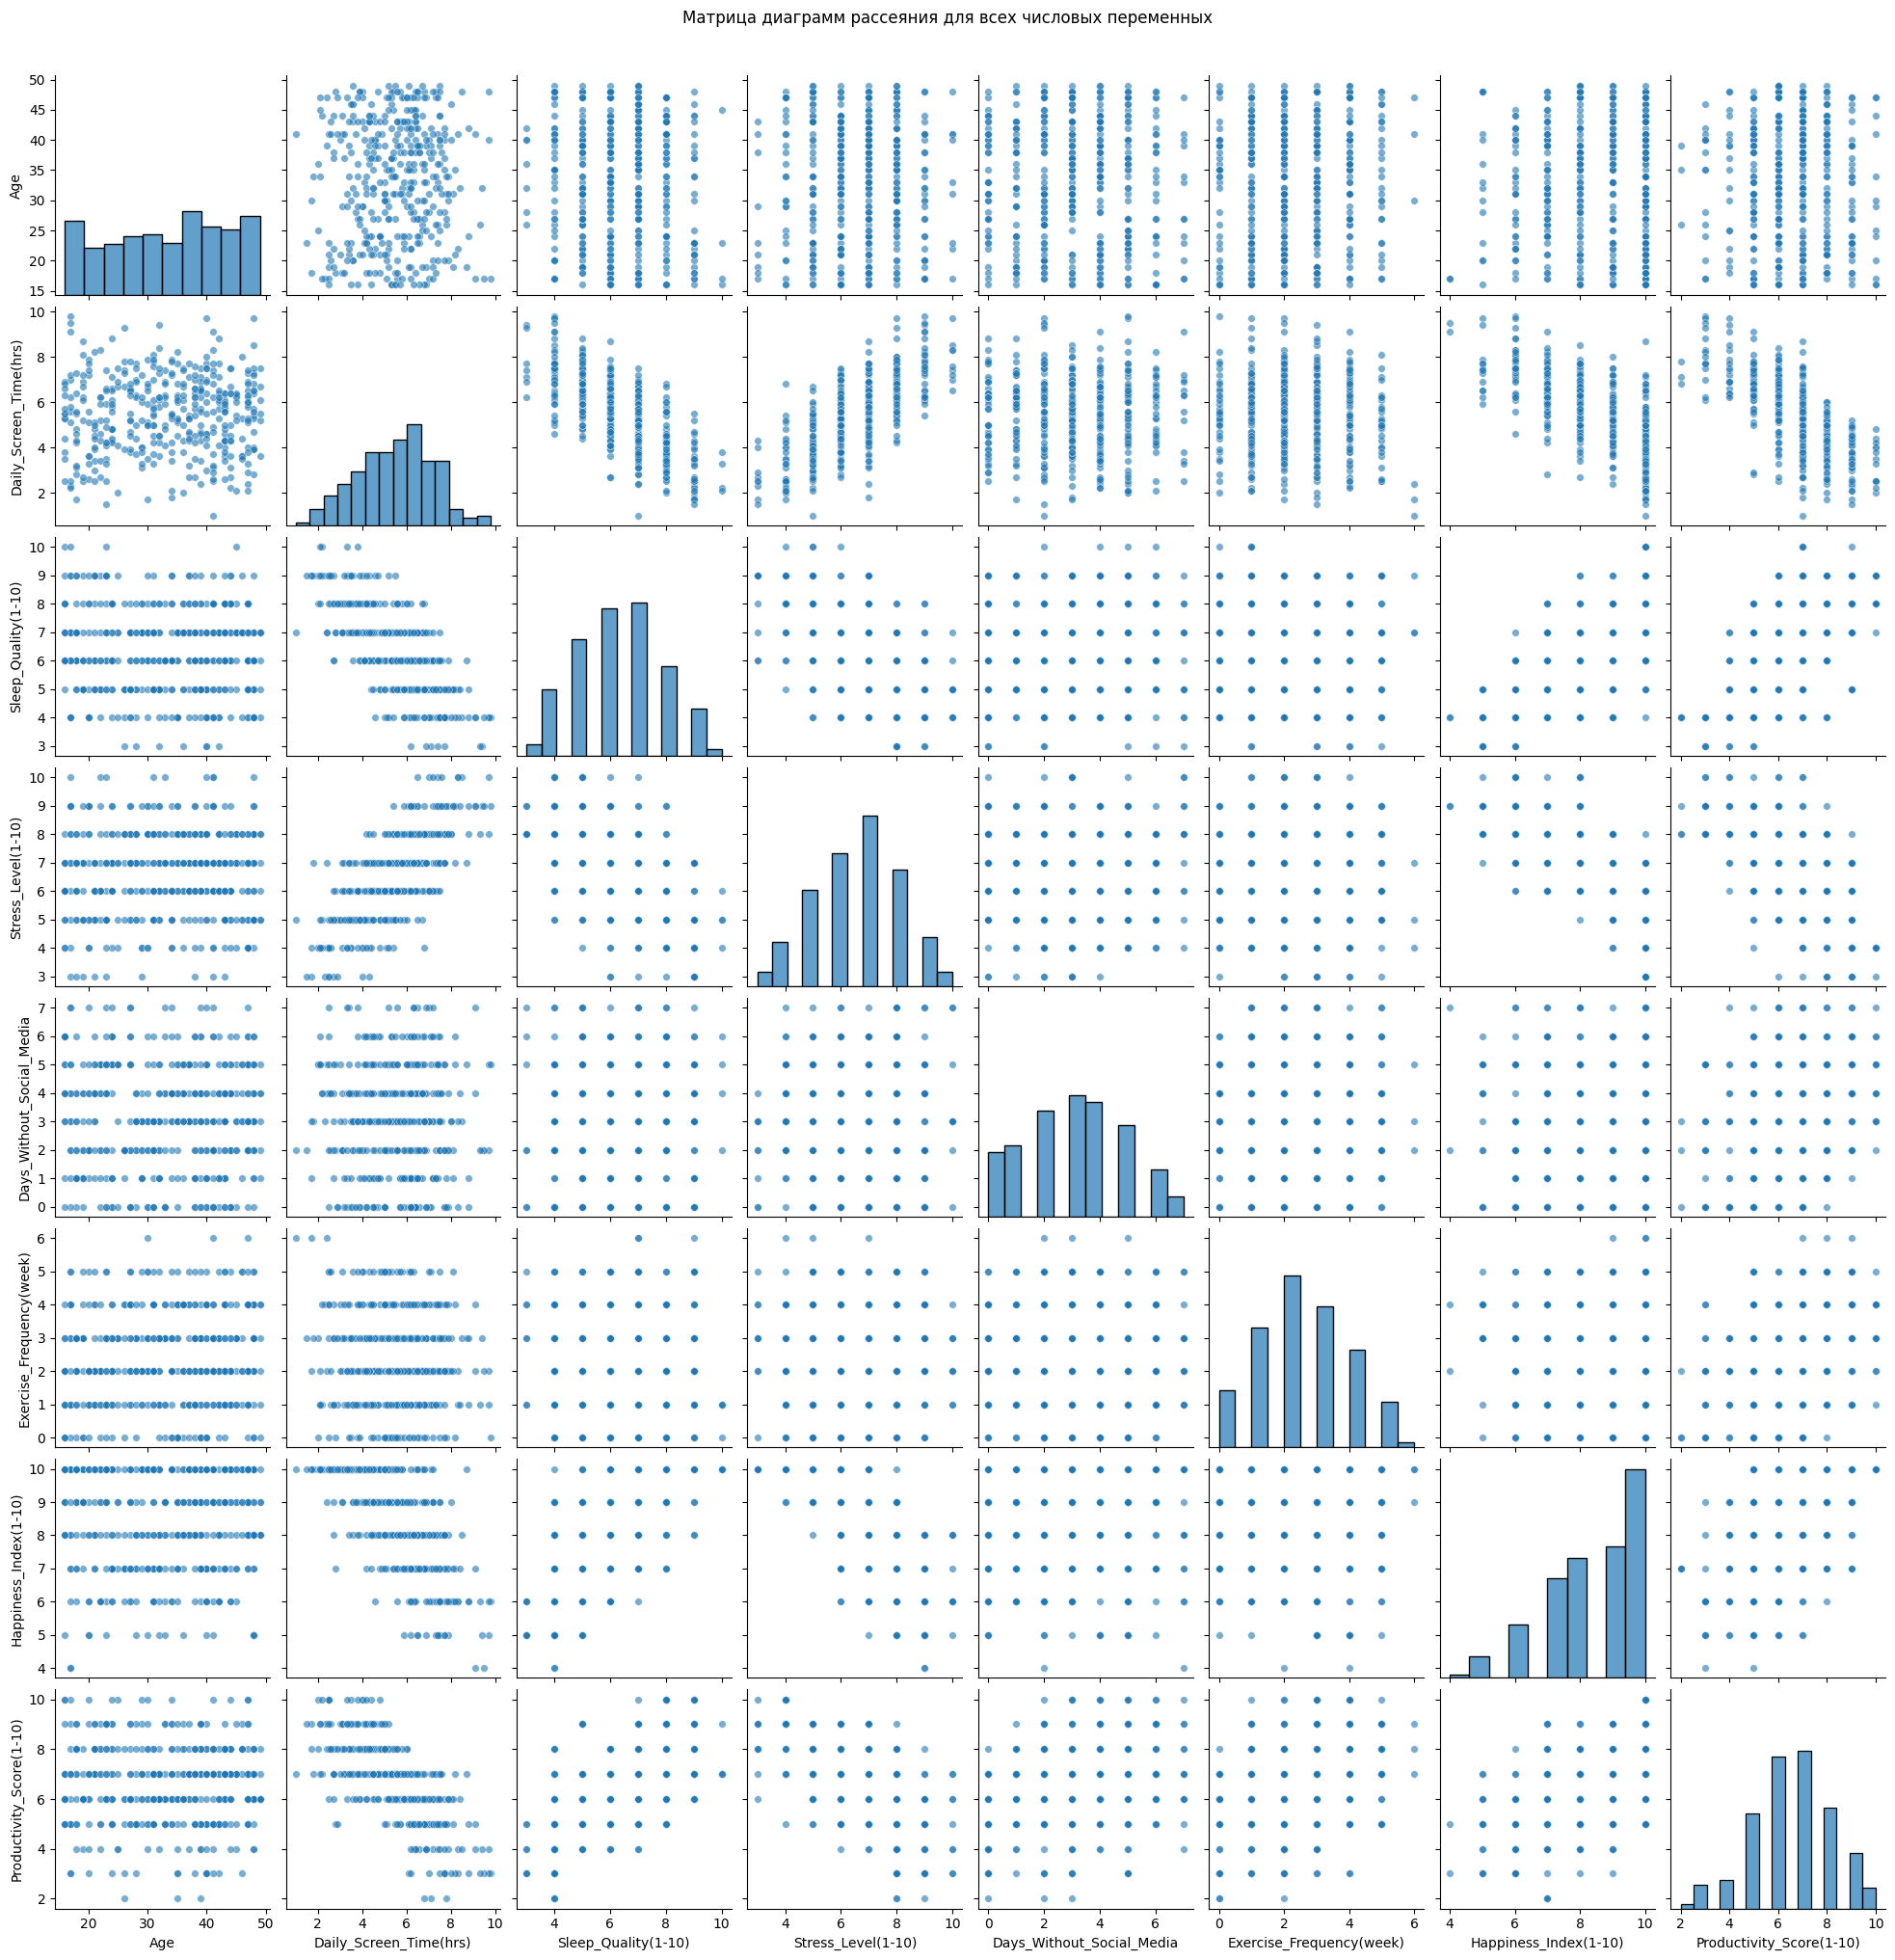

In [8]:
numeric_columns = [
    'Age', 'Daily_Screen_Time(hrs)', 'Sleep_Quality(1-10)',
    'Stress_Level(1-10)', 'Days_Without_Social_Media',
    'Exercise_Frequency(week)', 'Happiness_Index(1-10)',
    'Productivity_Score(1-10)'
]

sns.pairplot(df_cleaned[numeric_columns], 
             diag_kind='hist',
             plot_kws={'alpha': 0.6, 's': 30},
             diag_kws={'alpha': 0.7})
plt.suptitle('Матрица диаграмм рассеяния для всех числовых переменных', y=1.02)
plt.show()

### Рассмотрим графики корреляции продуктивности и других значений

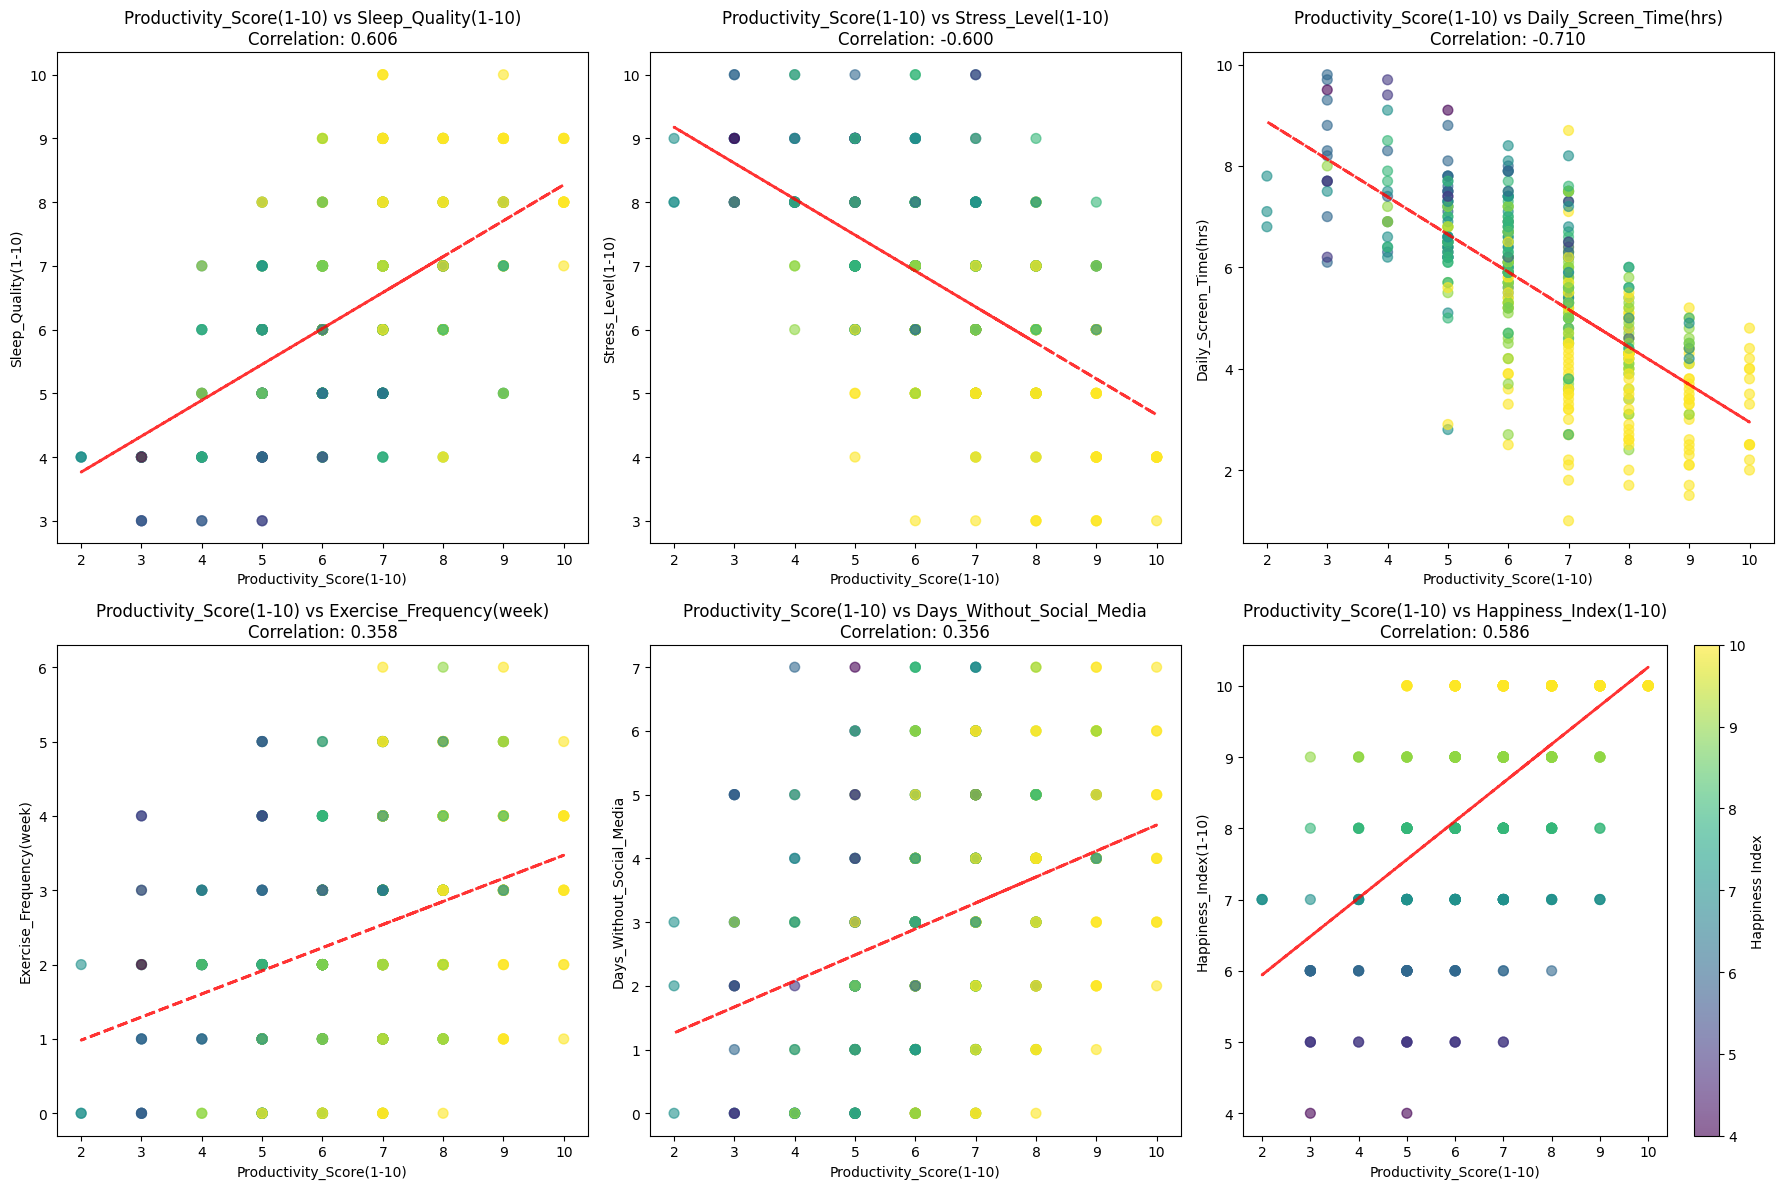

In [9]:
key_pairs = [
    ('Productivity_Score(1-10)', 'Sleep_Quality(1-10)'),
    ('Productivity_Score(1-10)', 'Stress_Level(1-10)'),
    ('Productivity_Score(1-10)', 'Daily_Screen_Time(hrs)'),
    ('Productivity_Score(1-10)', 'Exercise_Frequency(week)'),
    ('Productivity_Score(1-10)', 'Days_Without_Social_Media'),
    ('Productivity_Score(1-10)', 'Happiness_Index(1-10)'),
]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, (x_col, y_col) in enumerate(key_pairs):
    scatter = axes[i].scatter(df_cleaned[x_col], df_cleaned[y_col], alpha=0.6, c=df_cleaned['Happiness_Index(1-10)'], 
                             cmap='viridis', s=50)
    axes[i].set_xlabel(x_col)
    axes[i].set_ylabel(y_col)
    
    # Добавляем линию тренда
    z = np.polyfit(df_cleaned[x_col], df_cleaned[y_col], 1)
    p = np.poly1d(z)
    axes[i].plot(df_cleaned[x_col], p(df_cleaned[x_col]), "r--", alpha=0.8, linewidth=2)
    
    corr = df_cleaned[x_col].corr(df_cleaned[y_col])
    axes[i].set_title(f'{x_col} vs {y_col}\nCorrelation: {corr:.3f}')
    
    if i == len(key_pairs) - 1:
        cbar = plt.colorbar(scatter, ax=axes[i])
        cbar.set_label('Happiness Index')

plt.tight_layout()
plt.show()

### Работа с K-Mean

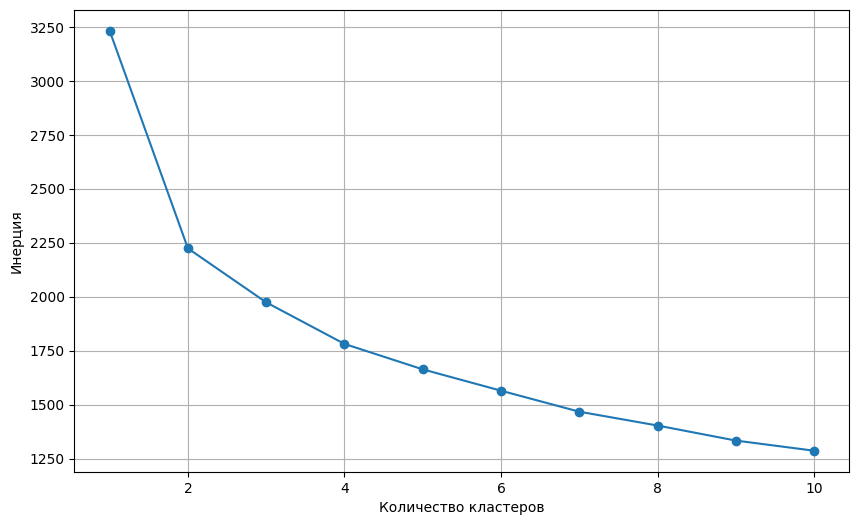

In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cleaned[numeric_columns])

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel('Количество кластеров')
plt.ylabel('Инерция')
plt.grid(True)
plt.show()


In [11]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)
df_cleaned['Cluster'] = clusters

<Figure size 1500x1200 with 0 Axes>

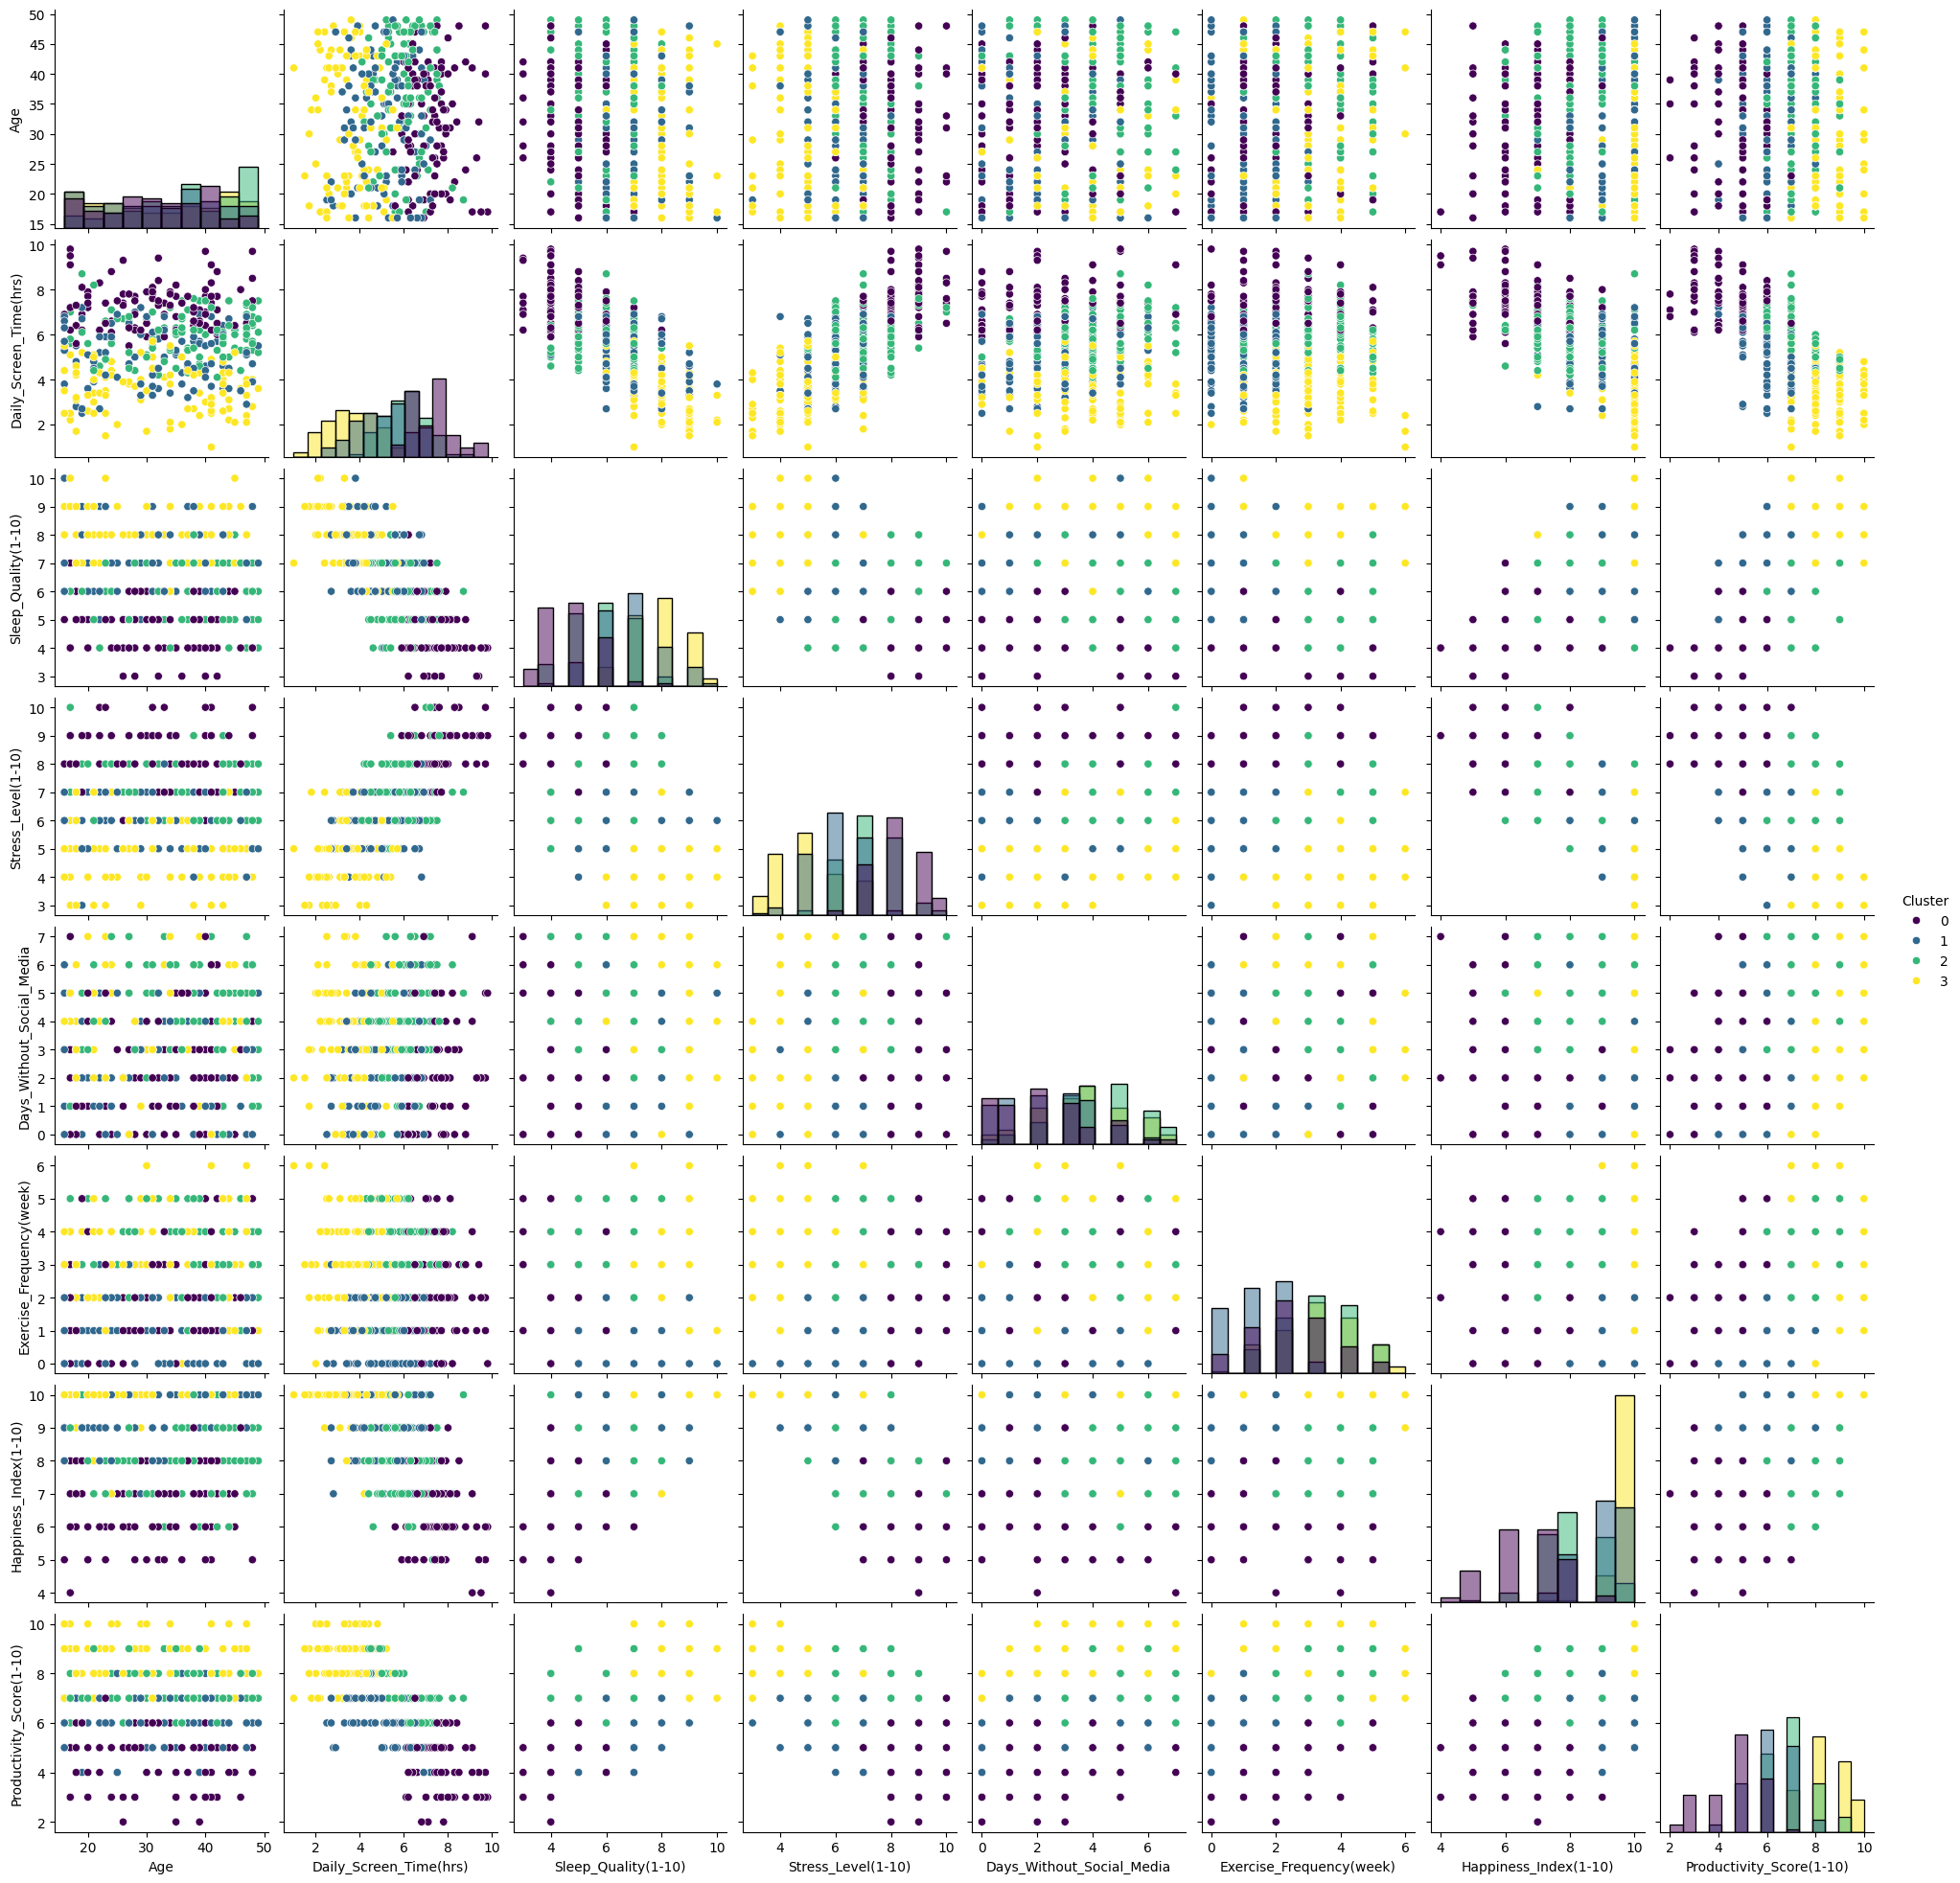

In [12]:
plt.figure(figsize=(15, 12))
sns.pairplot(df_cleaned, vars=numeric_columns, hue='Cluster', palette='viridis', diag_kind='hist')
plt.show()


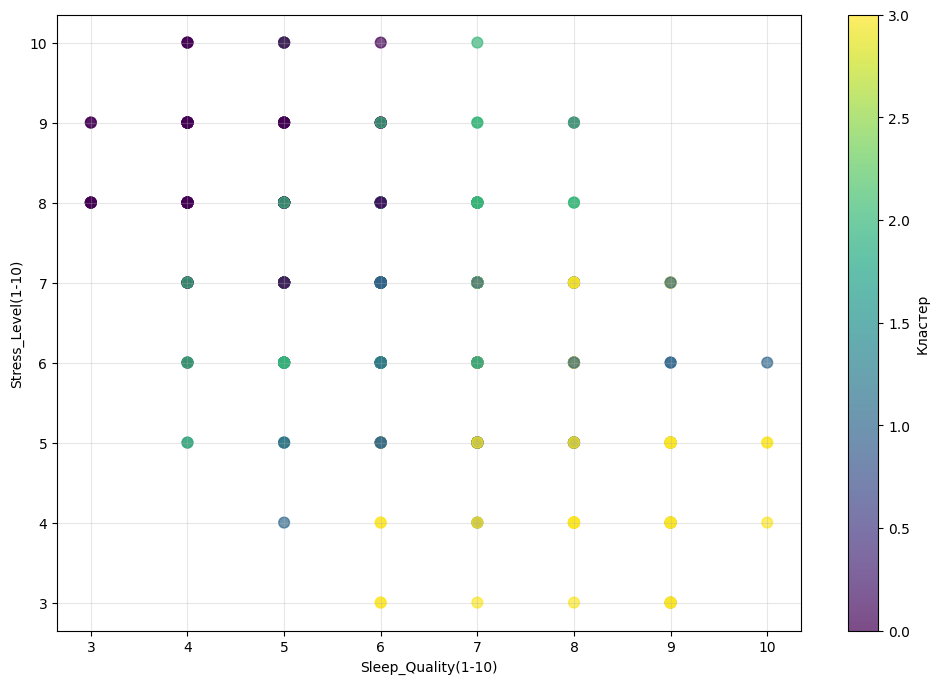

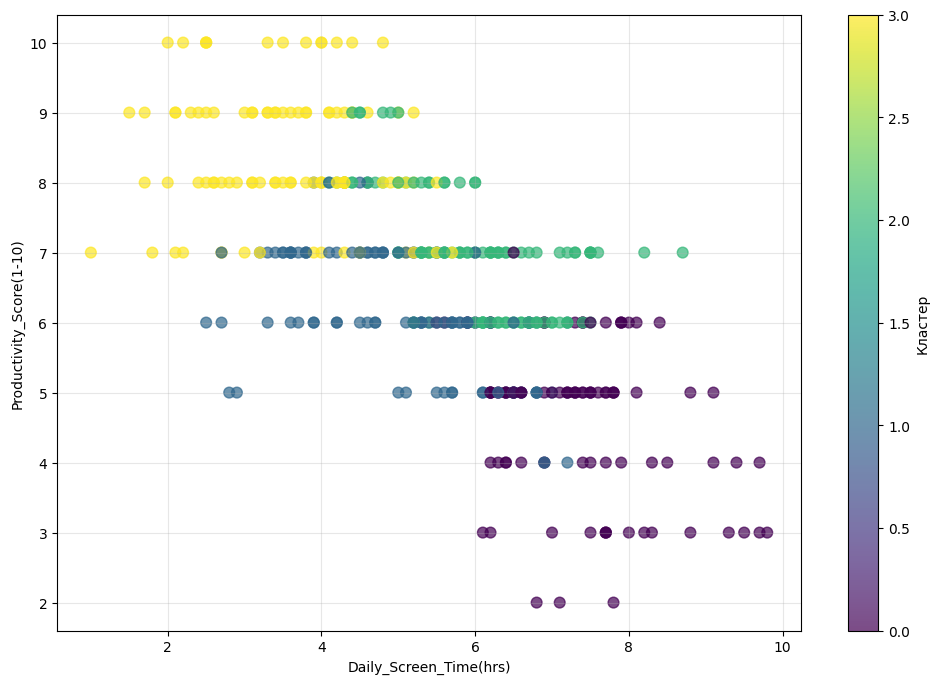

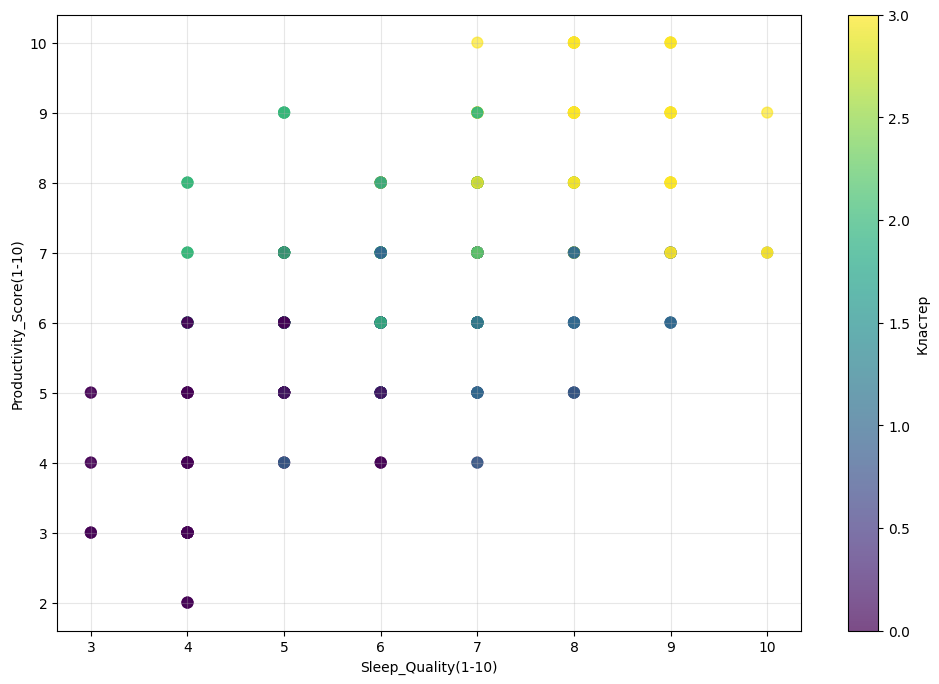

In [14]:
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df_cleaned['Sleep_Quality(1-10)'], 
                     df_cleaned['Stress_Level(1-10)'], 
                     c=df_cleaned['Cluster'], 
                     cmap='viridis', 
                     alpha=0.7, 
                     s=60)
plt.colorbar(scatter, label='Кластер')
plt.xlabel('Sleep_Quality(1-10)')
plt.ylabel('Stress_Level(1-10)')
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(12, 8))
scatter = plt.scatter(df_cleaned['Daily_Screen_Time(hrs)'], 
                     df_cleaned['Productivity_Score(1-10)'], 
                     c=df_cleaned['Cluster'], 
                     cmap='viridis', 
                     alpha=0.7, 
                     s=60)
plt.colorbar(scatter, label='Кластер')
plt.xlabel('Daily_Screen_Time(hrs)')
plt.ylabel('Productivity_Score(1-10)')
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(12, 8))
scatter = plt.scatter(df_cleaned['Sleep_Quality(1-10)'], 
                     df_cleaned['Productivity_Score(1-10)'], 
                     c=df_cleaned['Cluster'], 
                     cmap='viridis', 
                     alpha=0.7, 
                     s=60)
plt.colorbar(scatter, label='Кластер')
plt.xlabel('Sleep_Quality(1-10)')
plt.ylabel('Productivity_Score(1-10)')
plt.grid(True, alpha=0.3)
plt.show()

## Вывод

В этой работе в датасет был добавлено новое значение, которое коррелирует с качеством сна, кол-во стресса,экранным временем, кол-вом занятий спортом в не делю и дней без социальных сетей. Во время генерации были намеренно добавленны "грязные" данные, которые в последствии были найдины и удалены из дата сета.